In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# Save to df
applications = pd.read_csv("../Project4_data/application_record.csv", encoding = 'utf-8')
record = pd.read_csv("../Project4_Data/credit_record.csv", encoding = 'utf-8')

# Shape and preview
print('Application record df shape:', applications.shape)
applications.head()

Application record df shape: (438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
# Shape and preview
print('Credit record df shape:', record.shape)
record.head()

Credit record df shape: (1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
applications.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [6]:
record.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [8]:
print(f'Duplicates in applications df: {applications.iloc[:,1:].duplicated().sum()}')
print('')
print(f'Duplicates in record df: {record.duplicated().sum()}')

Duplicates in applications df: 348472

Duplicates in record df: 0


In [9]:
applications.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

Data Clean

In [10]:
# Drop duplicates
applications=applications.drop_duplicates(subset=applications.columns[1:], keep='first')

In [11]:
# Fill missing values
applications['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

In [12]:
# Drop constant feature, not useful
applications.drop('FLAG_MOBIL', axis=1, inplace=True)

Create target variable

Because the credit records are incomplete (the ID ranges in both dfs don't match) we have to create our own target. We do this by identifying 'low risk' and 'high risk' credit users. We say a user is 'high risk' if during any month they are late on payments by 30 days or more, and 'low risk' otherwise. This is the target we will try to predict later.

In [13]:
# Construct target
record['target']=record['STATUS']
record['target'].replace('X', 0, inplace=True)
record['target'].replace('C', 0, inplace=True)
record['target']=record['target'].astype(int)
record.loc[record['target']>=1,'target']=1

# target=1 (high risk) if there is at least one month where user is late on payments by 30 days or more
target_df=pd.DataFrame(record.groupby(['ID'])['target'].agg(max)).reset_index()

# Merge dataframes
new_df=pd.merge(applications, target_df, how='inner', on=['ID'])

Number of months the account is open correlates with the customer's riskiness (More chances to miss payments)

In [14]:
# Extract how many months account has been open for
start_df=pd.DataFrame(record.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()

# Rename column
start_df.rename(columns={'MONTHS_BALANCE':'ACCOUNT_LENGTH'}, inplace=True)

# Make entries positive
start_df['ACCOUNT_LENGTH']=-start_df['ACCOUNT_LENGTH']

# Merge dataframes on ID
new_df=pd.merge(new_df, start_df, how='inner', on=['ID'])

In [15]:
# Create age feature
new_df['AGE_YEARS']=-new_df['DAYS_BIRTH']/365.2425
new_df.drop('DAYS_BIRTH', axis=1, inplace=True)

# Create unemployed indicator
new_df['UNEMPLOYED']=0
new_df.loc[-new_df['DAYS_EMPLOYED']<0,'UNEMPLOYED']=1

# Create years employed feature
new_df['YEARS_EMPLOYED']=-new_df['DAYS_EMPLOYED']/365.2425
new_df.loc[new_df['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0
new_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

In [16]:
# Encode binary features
new_df["CODE_GENDER"] =  new_df["CODE_GENDER"].replace(['F','M'],[0,1])
new_df["FLAG_OWN_CAR"] = new_df["FLAG_OWN_CAR"].replace(["Y","N"],[1,0])
new_df["FLAG_OWN_REALTY"] = new_df["FLAG_OWN_REALTY"].replace(["Y","N"],[1,0])

In [17]:
new_df = new_df.rename(columns={'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Own_car', 
                               'FLAG_OWN_REALTY':'Own_property','CNT_CHILDREN':'Num_children',
                               'AMT_INCOME_TOTAL':'Total_income','NAME_INCOME_TYPE':'Income_type',
                               'NAME_EDUCATION_TYPE':'Education_type','NAME_FAMILY_STATUS':'Family_status',
                               'NAME_HOUSING_TYPE':'Housing_type','FLAG_WORK_PHONE':'Work_phone',
                               'FLAG_PHONE':'Phone','FLAG_EMAIL':'Email','OCCUPATION_TYPE':'Occupation_type',
                               'CNT_FAM_MEMBERS':'Num_family','target':'Target','ACCOUNT_LENGTH':'Account_length',
                                'AGE_YEARS':'Age','UNEMPLOYED':'Unemployed','YEARS_EMPLOYED':'Years_employed'})

In [32]:
new_df['Num_family']=new_df['Num_family'].astype(int)

In [33]:
new_df.columns

Index(['ID', 'Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone',
       'Email', 'Unemployed', 'Num_children', 'Num_family', 'Account_length',
       'Total_income', 'Age', 'Years_employed', 'Income_type',
       'Education_type', 'Family_status', 'Housing_type', 'Occupation_type',
       'Target'],
      dtype='object')

In [34]:
# Reordering
new_df=new_df[['ID', 'Gender', 'Own_car', 'Own_property', 'Work_phone',
               'Phone', 'Email', 'Unemployed', 'Num_children', 'Num_family', 
               'Account_length', 'Total_income', 'Age', 'Years_employed',  
               'Income_type', 'Education_type', 'Family_status',
               'Housing_type', 'Occupation_type','Target']]

In [35]:
print('Merged df shape:', new_df.shape)
new_df.head()

Merged df shape: (9709, 20)


,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [36]:
new_df.dtypes

ID                   int64
Gender               int64
Own_car              int64
Own_property         int64
Work_phone           int64
Phone                int64
Email                int64
Unemployed           int64
Num_children         int64
Num_family           int32
Account_length       int64
Total_income       float64
Age                float64
Years_employed     float64
Income_type         object
Education_type      object
Family_status       object
Housing_type        object
Occupation_type     object
Target               int32
dtype: object

In [23]:
# Save cleaned dataset
new_df.to_csv('clean_data.csv',index=False)

In [41]:
# Convert categorical features to numerical using LabelEncoder
le = LabelEncoder()
categorical_columns = ['Income_type', 'Education_type', 'Family_status', 'Housing_type',
       'Occupation_type']
for col in categorical_columns:
    new_df[col] = le.fit_transform(new_df[col])

In [42]:
# Load and preprocess data
# X = feature matrix, y = target variable (0 for not approved, 1 for approved)
X = new_df.drop('Target', axis=1)
y = new_df['Target']


In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
# Create an SVM classifier
svm_classifier = SVC()

# Train the SVM model
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8578784757981462


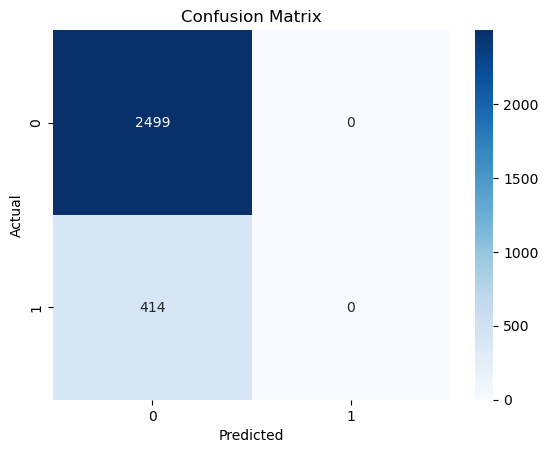

In [65]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()